# 002.02 - EDA - Goals

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np

import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.mlab as mlab

%matplotlib inline

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
#add the 'src' directory to path to import modules
PROJECT_DIR = pathlib.Path.cwd().resolve().parent
sys.path.append(str(PROJECT_DIR))

from src.visualization.visualize import vstacked_bar_charts, diagnose_discrete_fit
from src.visualization.fit_dists import fit_nbinom

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

DATA_DIR = PROJECT_DIR / 'data'
SCOPED_DATA_DIR = DATA_DIR / '03-scoped'

In [2]:
league = 'english-premier-league'
load_fp = SCOPED_DATA_DIR / league / str(league + '-scoped-1.csv')
seasons = ['2009-2010', '2010-2011', '2011-2012']

In [3]:
df = pd.read_csv(load_fp, parse_dates = ['date'], index_col=None)
df = df[df['season'].isin(seasons)]
# Calculate Results column
conditions = [df['h_ftgoals'] > df['a_ftgoals'],
              df['h_ftgoals'] == df['a_ftgoals'],
              df['h_ftgoals'] < df['a_ftgoals']]
choices = ['hwin', 'draw', 'awin']
df['result'] = np.select(conditions, choices, default='not-played')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1140 entries, 0 to 1139
Data columns (total 36 columns):
season                     1140 non-null object
date                       1140 non-null datetime64[ns]
h                          1140 non-null object
a                          1140 non-null object
h_ftgoals                  1140 non-null float64
a_ftgoals                  1140 non-null float64
h_htgoals                  1140 non-null float64
a_htgoals                  1140 non-null float64
h_corners                  1140 non-null float64
h_fouls                    1140 non-null float64
h_ycards                   1140 non-null float64
h_rcards                   1140 non-null float64
h_shots                    1140 non-null float64
h_sot                      1140 non-null float64
a_corners                  1140 non-null float64
a_fouls                    1140 non-null float64
a_ycards                   1140 non-null float64
a_rcards                   1140 non-null float64
a_shots

In [4]:
h_goals = df['h_ftgoals'].dropna().astype(int)
a_goals = df['a_ftgoals']#.dropna().astype('int')
# Need to deal with any goal value that has no occurrences in any game
# eg 2 games have 5 goals | 0 games have 6 goals | 1 game has 7 goals
# !! Important to do this every freq count
max_goals = df[['h_ftgoals', 'a_ftgoals']].max().max().astype(int)
h_goals_val_counts = h_goals.value_counts()
h_goals_dist = h_goals.value_counts().sort_index(). \
                    reindex(range(max_goals+1), fill_value=0)

a_goals_val_counts_a = a_goals.value_counts()
a_goals_dist = a_goals.value_counts().sort_index(). \
                    reindex(range(max_goals+1), fill_value=0)

goals_dists = pd.concat([h_goals_dist, a_goals_dist], axis=1)

print(f'Home and Away Goals Distributions:\n\n{goals_dists}\n')

Home and Away Goals Distributions:

   h_ftgoals  a_ftgoals
0        229        389
1        364        385
2        297        230
3        158         94
4         53         26
5         24         11
6          7          5
7          5          0
8          2          0
9          1          0



In [5]:
h_goals_mean = df['h_ftgoals'].mean()
h_goals_var = df['h_ftgoals'].var()

a_goals_mean = df['a_ftgoals'].mean()
a_goals_var = df['a_ftgoals'].var()

print('Home Goals Distribution:\n')
print(f'Mean:\t\t{h_goals_mean}')
print(f'Variance:\t{h_goals_var}\n')

print('Away Goals Distribution:\n')
print(f'Mean:\t\t{a_goals_mean}')
print(f'Variance:\t{a_goals_var}\n')

Home Goals Distribution:

Mean:		1.6368421052631579
Variance:	1.8205905457234075

Away Goals Distribution:

Mean:		1.1543859649122807
Variance:	1.319427629653583



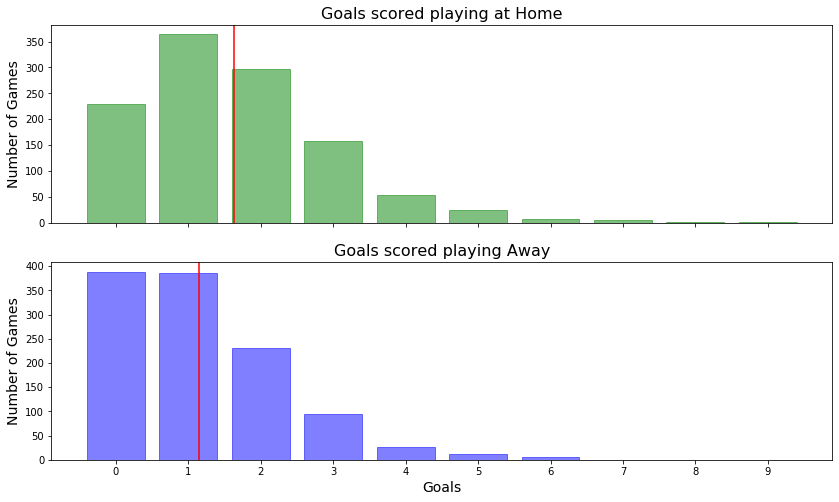

In [6]:
#plt.style.use('fivethirtyeight')
    
fig, (ax1, ax2) = vstacked_bar_charts(goals_dists.index, [goals_dists['h_ftgoals'], goals_dists['a_ftgoals']],
                                      figsize=(14,8))

ax1_bars = [rect.set_color('g') for rect in ax1.patches]
ax1.axvline(h_goals_mean, color='r')
ax1.set_title('Goals scored playing at Home', fontsize=16)
ax1.set_ylabel('Number of Games', fontsize=14)

ax2_bars = [rect.set_color('b') for rect in ax2.patches]
ax2.axvline(a_goals_mean, color='r')
ax2.set_title('Goals scored playing Away', fontsize=16)
ax2.set_ylabel('Number of Games', fontsize=14)
ax2.set_xlabel('Goals', fontsize=14)

tick_spacing = 1
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
plt.show();

Red Lines shows mean

The [Home Advantage](https://dashee87.github.io/data%20science/python/home-advantage-in-football-leagues-around-the-world/) effect shows up clearly in the means

For a Poisson distribution to work, we are looking for the mean and variance of each distribution to be equal.

For both home and away games - variance > mean (But not by much!), so there is possibly some overdispersion

### Home Goals Poisson Distribution Fit

Taking the mean to be equal to Poisson lambda parameter

In [7]:
# Get the expected values of a Poisson distribution with the same mu
norm_exp = stats.poisson.pmf(goals_dists.index, h_goals_mean)
exp = norm_exp * goals_dists['h_ftgoals'].sum()
h_goals_poiss = pd.DataFrame(np.vstack([goals_dists['h_ftgoals'].values, exp, norm_exp])).T
h_goals_poiss.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_poiss['obs_norm'] = h_goals_poiss['obs']/ h_goals_poiss['obs'].sum()
h_goals_poiss

,obs,exp,exp_norm,obs_norm
0,229.0,221.836680,0.194594,0.200877
1,364.0,363.111619,0.318519,0.319298
2,297.0,297.178193,0.260683,0.260526
3,158.0,162.144593,0.142232,0.138596
4,53.0,66.351274,0.058203,0.046491
5,24.0,21.721312,0.019054,0.021053
6,7.0,5.925726,0.005198,0.006140
7,5.0,1.385640,0.001215,0.004386
8,2.0,0.283509,0.000249,0.001754
9,1.0,0.051562,0.000045,0.000877


In [8]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_poiss['obs'],
                              f_exp=h_goals_poiss['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
ks = stats.kstest(h_goals_poiss['obs'],
                  'poisson',
                  [h_goals_mean])

print(f'Pearson:\n{chi2}\n')
print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=40.72575287399042, pvalue=2.3457249622011605e-06)

KS:
KstestResult(statistic=0.7932839219493562, pvalue=3.1343173150849775e-07)



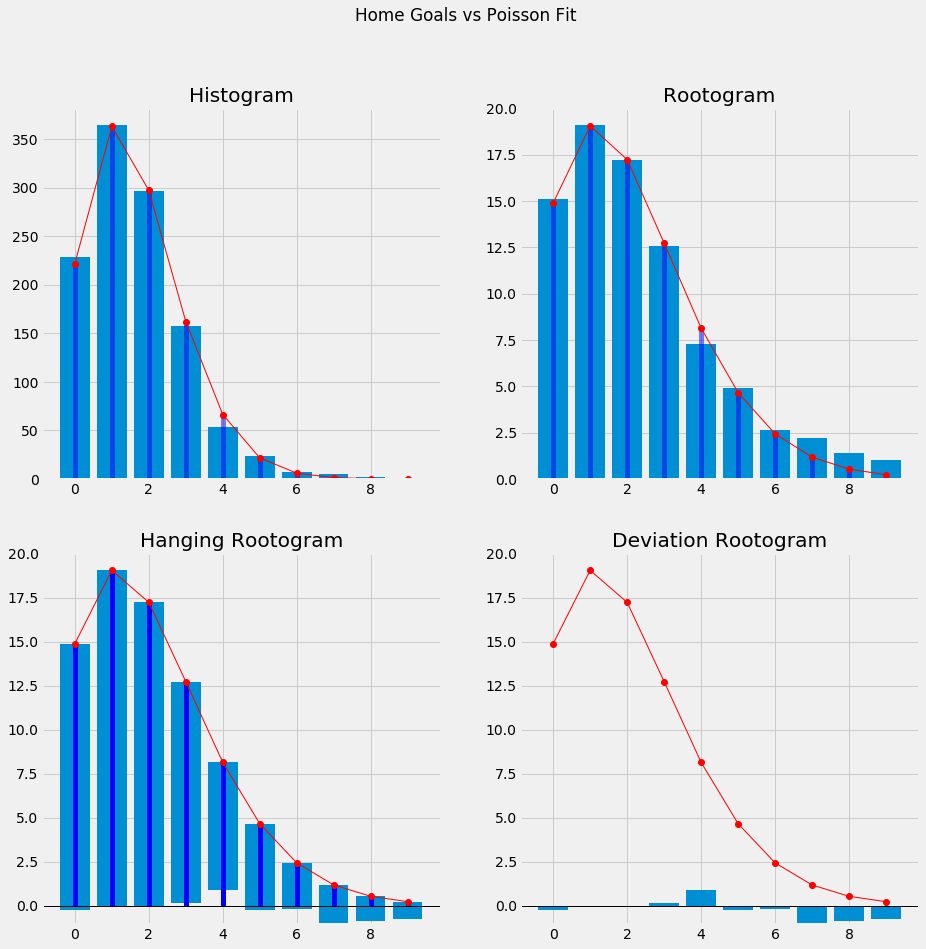

In [9]:
plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_goals_poiss.index,
                                  h_goals_poiss['obs'],
                                  h_goals_poiss['exp'])
plt.suptitle('Home Goals vs Poisson Fit')

plt.show();

### Away Goals Poisson Distribution Fit

Taking the mean to be equal to Poisson lambda parameter

In [10]:
# Get the expected values of a Poisson distribution with the same mu
norm_exp = stats.poisson.pmf(goals_dists.index, a_goals_mean)
exp = norm_exp * goals_dists['a_ftgoals'].sum()
a_goals_poiss = pd.DataFrame(np.vstack([goals_dists['a_ftgoals'].values, exp, norm_exp])).T
a_goals_poiss.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
a_goals_poiss['obs_norm'] = a_goals_poiss['obs']/ a_goals_poiss['obs'].sum()
a_goals_poiss

,obs,exp,exp_norm,obs_norm
0,389.0,359.386200,0.315251,0.341228
1,385.0,414.870385,0.363921,0.337719
2,230.0,239.460275,0.210053,0.201754
3,94.0,92.143194,0.080827,0.082456
4,26.0,26.592202,0.023326,0.022807
5,11.0,6.139533,0.005386,0.009649
6,5.0,1.181232,0.001036,0.004386
7,0.0,0.194800,0.000171,0.000000
8,0.0,0.028109,0.000025,0.000000
9,0.0,0.003605,0.000003,0.000000


In [11]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(a_goals_poiss['obs'],
                              f_exp=a_goals_poiss['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
ks = stats.kstest(a_goals_poiss['obs'],
                  'poisson',
                  [a_goals_mean])

print(f'Pearson:\n{chi2}\n')
print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=21.435170506355405, pvalue=0.006077010836096536)

KS:
KstestResult(statistic=0.6987647275468356, pvalue=2.0491808281563734e-05)



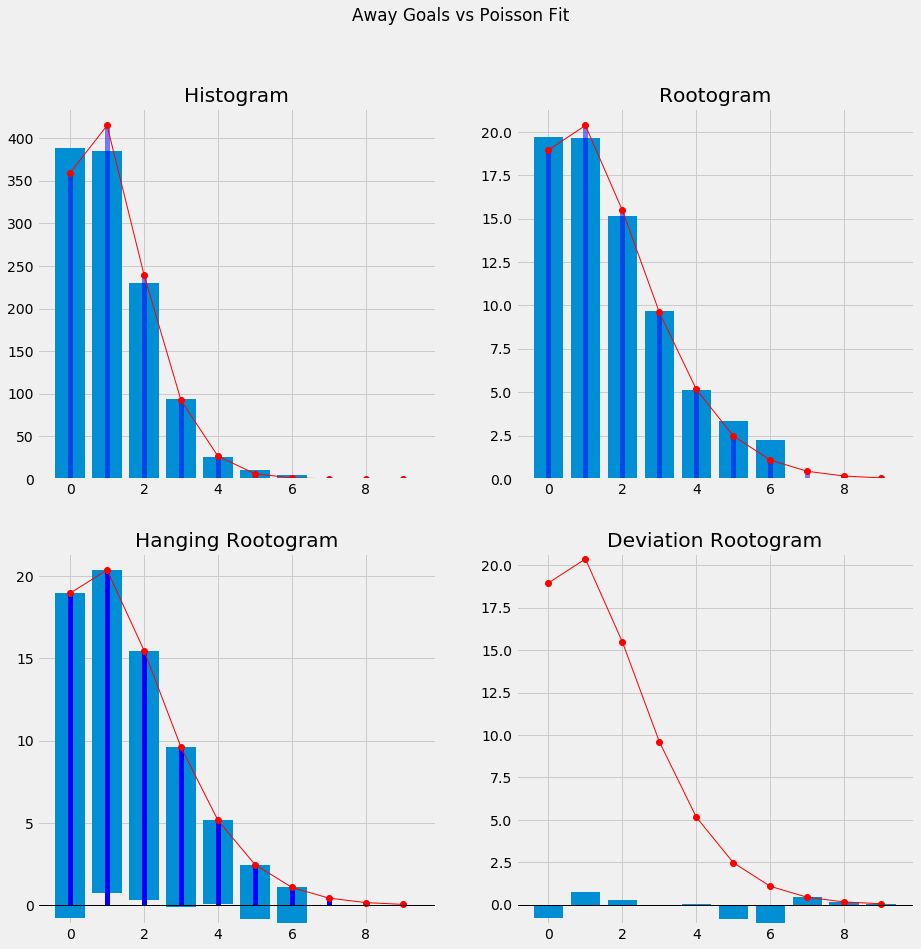

In [12]:
plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(a_goals_poiss.index,
                                  a_goals_poiss['obs'],
                                  a_goals_poiss['exp'])
plt.suptitle('Away Goals vs Poisson Fit')

plt.show();

### Home Goals Negative Binomial Distribution Fit



#### Method 1 to estimate parameters

In [13]:
# Fit the negative binomial to estimate the parameters
param_dict = fit_nbinom(df['h_ftgoals'])
print(param_dict)

{'size': 14.709126462498348, 'prob': 0.899856340611582}


In [14]:
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
mean, var, skew, kurt = stats.nbinom.stats(param_dict['size'], param_dict['prob'], moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_goals_mean:\t{h_goals_mean}\th_goals_var:\t{h_goals_var}')

mean:		1.6369565717128443	variance:	1.8191310077342973
h_goals_mean:	1.6368421052631579	h_goals_var:	1.8205905457234075


In [15]:
# These look good

In [16]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(goals_dists.index, param_dict['size'], param_dict['prob'])

exp = norm_exp * goals_dists['h_ftgoals'].sum()
h_goals_nbinom = pd.DataFrame(np.vstack([goals_dists['h_ftgoals'].values, exp, norm_exp])).T
h_goals_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_nbinom['obs_norm'] = h_goals_nbinom['obs']/ h_goals_nbinom['obs'].sum()
h_goals_nbinom

,obs,exp,exp_norm,obs_norm
0,229.0,241.452873,0.211801,0.200877
1,364.0,355.666300,0.311988,0.319298
2,297.0,279.761671,0.245405,0.260526
3,158.0,156.042954,0.136880,0.138596
4,53.0,69.183856,0.060688,0.046491
5,24.0,25.924580,0.022741,0.021053
6,7.0,8.528081,0.007481,0.006140
7,5.0,2.526612,0.002216,0.004386
8,2.0,0.686617,0.000602,0.001754
9,1.0,0.173498,0.000152,0.000877


In [17]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_nbinom['obs'],
                              f_exp=h_goals_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=14.997559545099028, pvalue=0.059192930321263965)



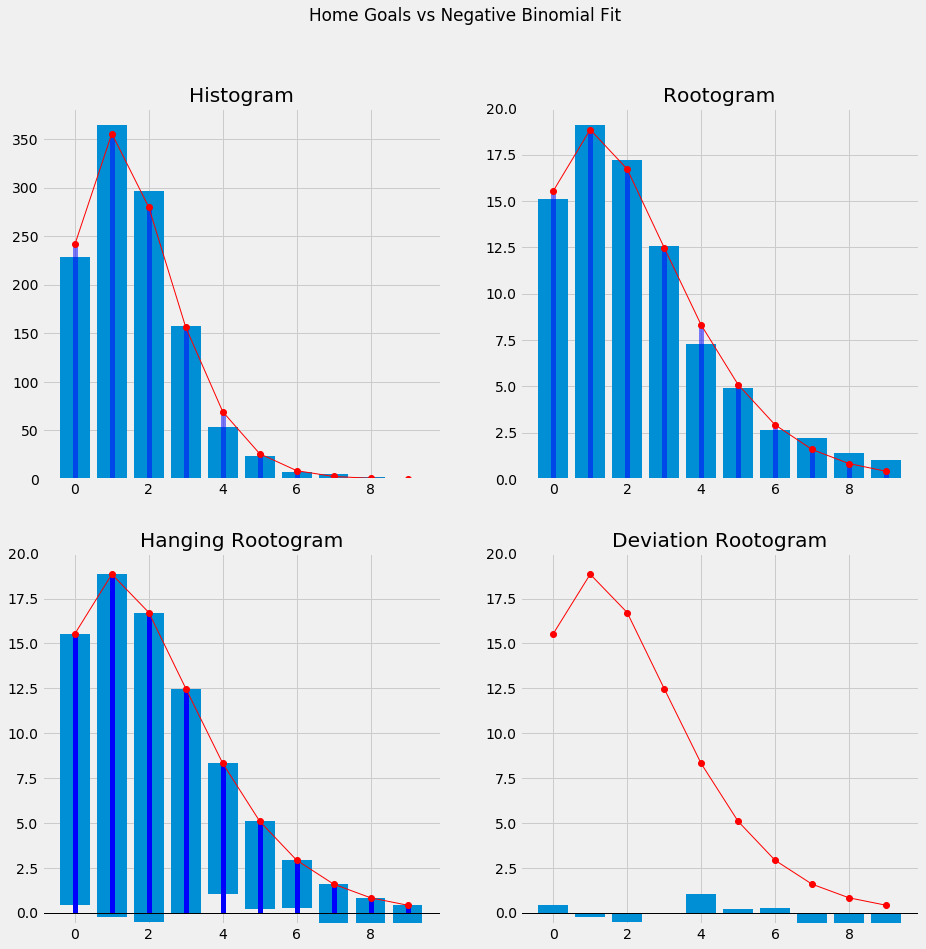

In [18]:
plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_goals_nbinom.index,
                                  h_goals_nbinom['obs'],
                                  h_goals_nbinom['exp'])
plt.suptitle('Home Goals vs Negative Binomial Fit')

plt.show();

#### Method 2 to estimate parameters

**Thinking about Negative Binomial Distributions**

We'll consider a negative binomial distribution like this.

+ An alternative to the Poisson Distribution where the variance of the distribution is greater than the mean

Simple Version of Method of Moments Estimators for Negative Binomial Parameters

$$ \hat p = \frac {\bar x}{s^2}$$

$$ \hat n = \frac {\bar x ^ 2}{s^2 - \bar x}$$

where:
+ $x$  is sample mean of the observed distribution
+ $s^2$ is the sample variance of the observed distribution

In [19]:
p = h_goals_mean/(h_goals_var)
n = h_goals_mean**2/ (h_goals_var - h_goals_mean)
param_dict = fit_nbinom(df['h_ftgoals'])

print(f'p:\t{p}')
print(f'n:\t{n}')

p:	0.89907206708731
n:	14.581087441348545


In [20]:
print(f'Home Mean Goals:\t{h_goals_mean}')
print(f'Home Mean variance:\t{h_goals_var}\n')

mean, var, skew, kurt = stats.nbinom.stats(n, p, moments='mvsk')
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'h_goals_mean:\t{h_goals_mean}\th_goals_var:\t{h_goals_var}')

Home Mean Goals:	1.6368421052631579
Home Mean variance:	1.8205905457234075

mean:		1.6368421052631594	variance:	1.8205905457234095
h_goals_mean:	1.6368421052631579	h_goals_var:	1.8205905457234075


In [21]:
# These look good for a lot less effort

In [22]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp2 = stats.nbinom.pmf(goals_dists.index, n, p)

exp2 = norm_exp2 * goals_dists['h_ftgoals'].sum()
h_goals_nbinom2 = pd.DataFrame(np.vstack([goals_dists['h_ftgoals'].values, exp2, norm_exp2])).T
h_goals_nbinom2.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
h_goals_nbinom2['obs_norm'] = h_goals_nbinom2['obs']/ h_goals_nbinom2['obs'].sum()
h_goals_nbinom2

,obs,exp,exp_norm,obs_norm
0,229.0,241.645375,0.211970,0.200877
1,364.0,355.614762,0.311943,0.319298
2,297.0,279.614010,0.245275,0.260526
3,158.0,155.977538,0.136822,0.138596
4,53.0,69.192526,0.060695,0.046491
5,24.0,25.952051,0.022765,0.021053
6,7.0,8.548081,0.007498,0.006140
7,5.0,2.536590,0.002225,0.004386
8,2.0,0.690629,0.000606,0.001754
9,1.0,0.174887,0.000153,0.000877


In [23]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(h_goals_nbinom2['obs'],
                              f_exp=h_goals_nbinom2['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=14.950941661549512, pvalue=0.0601064174070193)



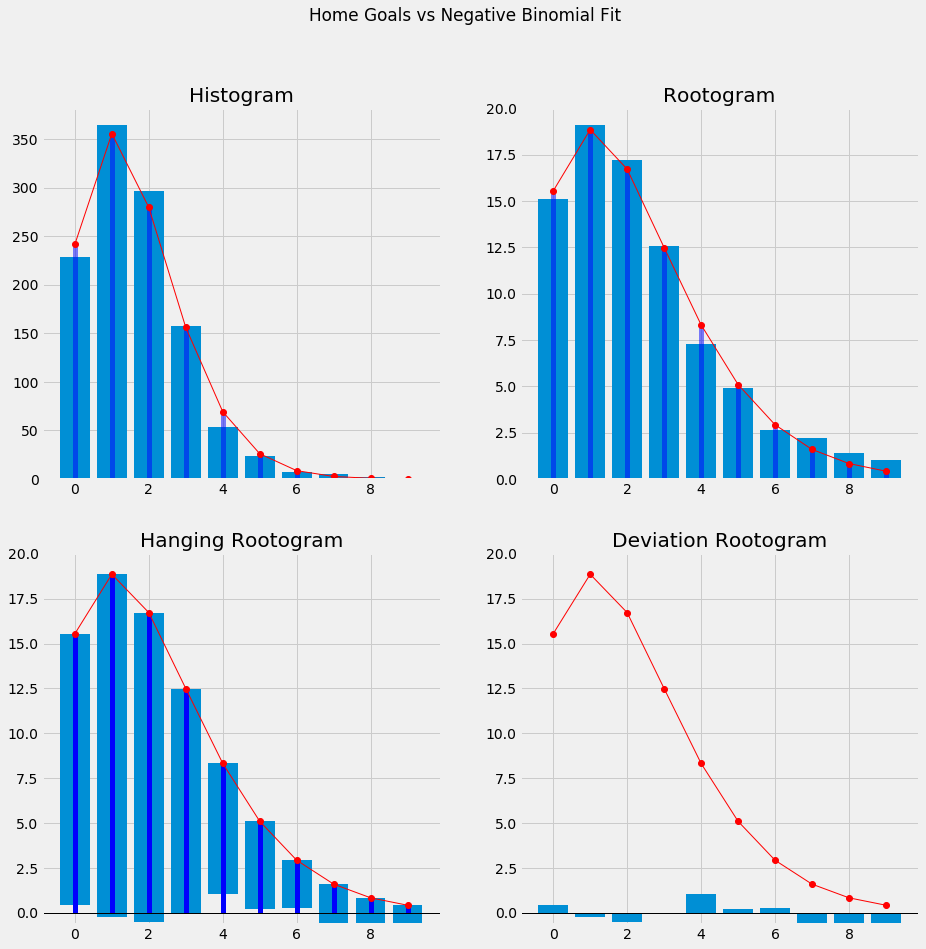

In [24]:
plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(h_goals_nbinom2.index,
                                  h_goals_nbinom2['obs'],
                                  h_goals_nbinom2['exp'])
plt.suptitle('Home Goals vs Negative Binomial Fit')

plt.show();

In [25]:
# Looks worse than Poisson !

### Away Goals Negative Binomial Distribution Fit



Use Simple Version of Method of Moments Estimators for Negative Binomial Parameters (Method 2)

$$ \hat p = \frac {\bar x}{s^2}$$

$$ \hat n = \frac {\bar x ^ 2}{s^2 - \bar x}$$

where:
+ $x$  is sample mean of the observed distribution
+ $s^2$ is the sample variance of the observed distribution

In [26]:
p = a_goals_mean/(a_goals_var)
n = a_goals_mean**2/ (a_goals_var - a_goals_mean)
param_dict = fit_nbinom(df['a_ftgoals'])

print(f'p:\t{p}')
print(f'n:\t{n}')

p:	0.8749141968592593
n:	8.074366906534046


In [27]:
print(f'Away Mean Goals:\t{a_goals_mean}')
print(f'Away Mean variance:\t{a_goals_var}\n')

mean, var, skew, kurt = stats.nbinom.stats(n, p, moments='mvsk')
# Check that we are on the right track by plugging the params into stats and comparing them to what we know 
#from scipy.stats import nbinom
# Get the expected values of a Negative Binomial distribution with the n, psame mu
# mean, var, skew, kurt = nbinom.stats(n, p, moments='mvsk')
print(f'mean:\t\t{mean}\tvariance:\t{var}')
print(f'a_goals_mean:\t{a_goals_mean}\ta_goals_var:\t{a_goals_var}')

Away Mean Goals:	1.1543859649122807
Away Mean variance:	1.319427629653583

mean:		1.1543859649122807	variance:	1.319427629653583
a_goals_mean:	1.1543859649122807	a_goals_var:	1.319427629653583


In [28]:
#norm_exp = stats.nbinom.pmf(k, n, p, loc=0)
norm_exp = stats.nbinom.pmf(goals_dists.index, n, p)

exp = norm_exp * goals_dists['a_ftgoals'].sum()
a_goals_nbinom = pd.DataFrame(np.vstack([goals_dists['a_ftgoals'].values, exp, norm_exp])).T
a_goals_nbinom.rename(columns={0:'obs', 1:'exp', 2: 'exp_norm' }, inplace=True)
a_goals_nbinom['obs_norm'] = a_goals_nbinom['obs']/ a_goals_nbinom['obs'].sum()
a_goals_nbinom

,obs,exp,exp_norm,obs_norm
0,389.0,387.536589,0.339944,0.341228
1,385.0,391.407563,0.343340,0.337719
2,230.0,222.138367,0.194858,0.201754
3,94.0,93.309982,0.081851,0.082456
4,26.0,32.314322,0.028346,0.022807
5,11.0,9.761070,0.008562,0.009649
6,5.0,2.660571,0.002334,0.004386
7,0.0,0.669135,0.000587,0.000000
8,0.0,0.157714,0.000138,0.000000
9,0.0,0.035235,0.000031,0.000000


In [29]:
# Use a Chi squared Test
# and KS Test - maybe not suitable for discrete distributions?

chi2 = stats.power_divergence(a_goals_nbinom['obs'],
                              f_exp=a_goals_nbinom['exp'],
                              lambda_="pearson",
                             ddof=1, axis=0)
#ks = stats.kstest(h_goals_nbinom['obs'],
#                  'poisson',
#                  [h_goals_nbinom])

print(f'Pearson:\n{chi2}\n')
#print(f'KS:\n{ks}\n')

Pearson:
Power_divergenceResult(statistic=4.703977259991701, pvalue=0.7886959733108633)



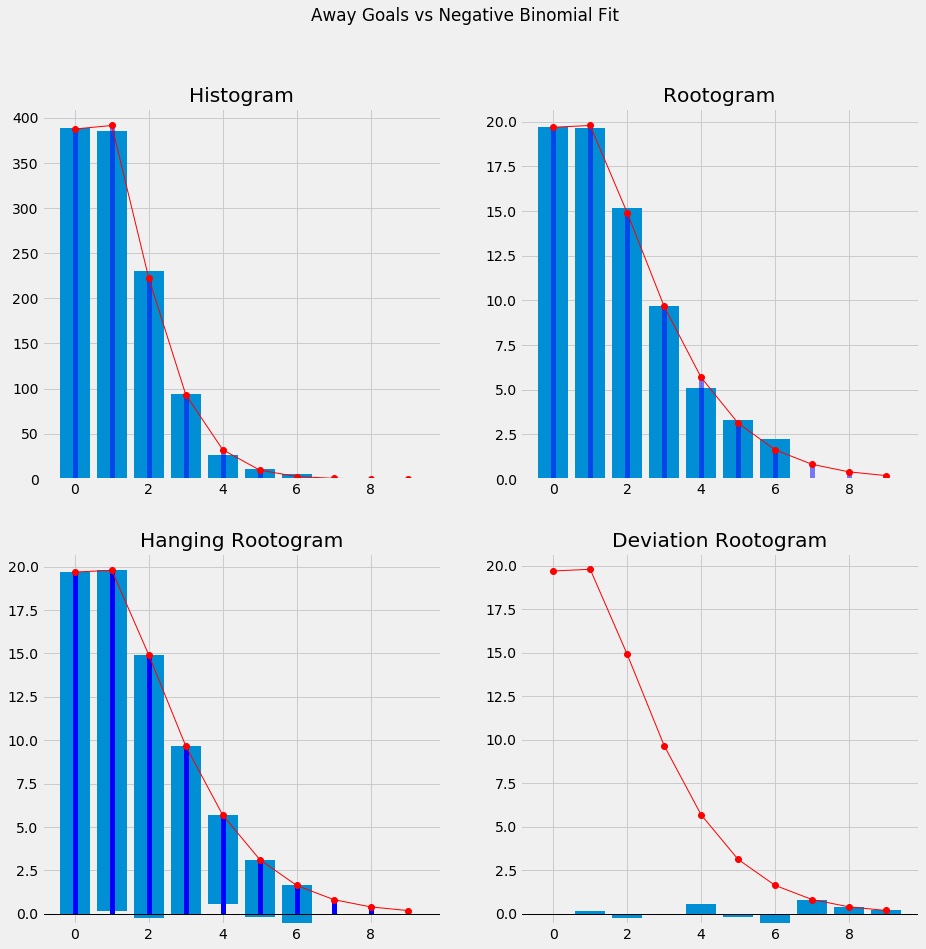

In [30]:
plt.style.use('fivethirtyeight')
fig, axes = diagnose_discrete_fit(a_goals_nbinom.index,
                                  a_goals_nbinom['obs'],
                                  a_goals_nbinom['exp'])
plt.suptitle('Away Goals vs Negative Binomial Fit')

plt.show();

In [31]:
# Nice !

## References

Visualizing Categorical Data by Michael Friendly - Copyright SAS Institute - ISBN 1-58025-660-0

https://stats.stackexchange.com/questions/78139/how-to-know-if-a-data-follows-a-poisson-distribution-in-r

https://stats.stackexchange.com/questions/328803/python-test-if-my-data-follow-a-poisson-exponential-distribution

https://blogs.sas.com/content/iml/2012/04/12/the-poissonness-plot-a-goodness-of-fit-diagnostic.html

https://github.com/gokceneraslan/fit_nbinom/blob/master/fit_nbinom.py